# Install Packages

In [1]:
!pip install duckdb --pre --upgrade 
!pip install polars --upgrade       
!pip install datafusion             

StatementMeta(, 4f7b9513-9c96-4853-b0bc-05666154b9da, 3, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 144.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 125.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 115.5 MB/s eta 0:00:0000:0100:01


In [2]:
sf =30

StatementMeta(, 4f7b9513-9c96-4853-b0bc-05666154b9da, 4, Finished, Available)

In [3]:
%%time

import duckdb
import pathlib
import os

if not os.path.isdir(f'/lakehouse/default/Files/{sf}'):
    for x in range(0, sf) :
        con=duckdb.connect()
        con.sql('PRAGMA disable_progress_bar;SET preserve_insertion_order=false')
        con.sql(f"CALL dbgen(sf={sf} , children ={sf}, step = {x})") 
        for tbl in ['lineitem'] :
            pathlib.Path(f'/lakehouse/default/Files/{sf}/{tbl}').mkdir(parents=True, exist_ok=True) 
            con.sql(f"COPY (SELECT * FROM {tbl}) TO '/lakehouse/default/Files/{sf}/{tbl}/{x:03d}.parquet' ")
        con.close()

StatementMeta(, 4f7b9513-9c96-4853-b0bc-05666154b9da, 5, Finished, Available)

CPU times: user 49.7 ms, sys: 12.9 ms, total: 62.6 ms
Wall time: 561 ms


In [4]:
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = 'Sorting Lineitem-SF'+str(sf)+' ,Fabric Notebook, '+vCPU+' '+str(mem)+'GB'
runtime

StatementMeta(, 4f7b9513-9c96-4853-b0bc-05666154b9da, 6, Finished, Available)

'Sorting Lineitem-SF30 ,Fabric Notebook, 8 vCPU 63.0GB'

In [5]:
import os
mypath = f"/lakehouse/default/Files/{sf}/Sort/"
os.makedirs(mypath, exist_ok=True)
for root, dirs, files in os.walk(mypath, topdown=False):
    for file in files:
        os.remove(os.path.join(root, file))

    # Add this block to remove folders
    for dir in dirs:
        os.rmdir(os.path.join(root, dir))

StatementMeta(, 4f7b9513-9c96-4853-b0bc-05666154b9da, 7, Finished, Available)

# DuckDB

In [6]:
%%time
import time
start = time.time()
import duckdb
con=duckdb.connect()
con.sql(
f'''
PRAGMA disable_progress_bar;
COPY  (select * from '/lakehouse/default/Files/{sf}/lineitem/*.parquet' order by l_shipdate )
to '/lakehouse/default/Files/{sf}/Sort/lineitem_DuckDB_Sort' (FORMAT 'PARQUET', PER_THREAD_OUTPUT TRUE)
''')
con.close()
duckdb_duration = time.time()-start

StatementMeta(, 4f7b9513-9c96-4853-b0bc-05666154b9da, 8, Finished, Available)

CPU times: user 7min 57s, sys: 1min 24s, total: 9min 22s
Wall time: 1min 50s


# DataFusion

In [7]:
%%time
start = time.time()
from datafusion import SessionContext
ctx = SessionContext()
ctx.register_parquet('lineitem', f'/lakehouse/default/Files/{sf}/lineitem/*.parquet')
df = ctx.sql("select * from lineitem order by l_shipdate")
df.write_parquet(f"/lakehouse/default/Files/{sf}/Sort/lineitem_Datafusion_Sort")
Datafusion_duration = time.time()-start

StatementMeta(, 4f7b9513-9c96-4853-b0bc-05666154b9da, 9, Finished, Available)

CPU times: user 6min 30s, sys: 46.5 s, total: 7min 16s
Wall time: 3min 9s


# Spark

In [8]:
%%time
import time
start = time.time()
df = spark.read.parquet(f"Files/{sf}/lineitem/*.parquet")
df.orderBy("l_shipdate")
df.write.mode("overwrite").format("parquet").save(f"Files/{sf}/Sort/Lineitem_Spark_Sort")
Spark_duration = time.time()-start

StatementMeta(, 4f7b9513-9c96-4853-b0bc-05666154b9da, 10, Finished, Available)

CPU times: user 21.9 ms, sys: 5.92 ms, total: 27.8 ms
Wall time: 2min 7s


# Polars

In [ ]:
%%time
#start = time.time()
#import polars as pl
#pl.scan_parquet(f"/lakehouse/default/Files/{sf}/lineitem/*.parquet")\
#.sort("l_shipdate").sink_parquet(f"/lakehouse/default/Files/{sf}/Sort/lineitem_sort_polars.parquet")
#polars_duration = time.time()-start

# Result

StatementMeta(, 4f7b9513-9c96-4853-b0bc-05666154b9da, 15, Finished, Available)

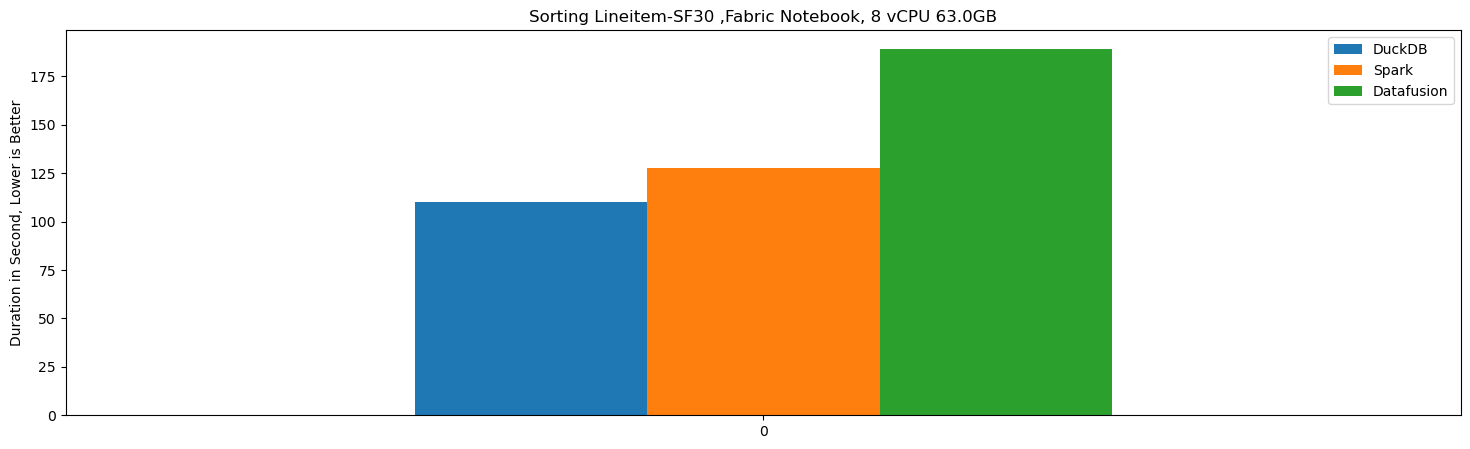

In [13]:
import pandas as pd
#df = pd.DataFrame([{'DuckDB':duckdb_duration, 'Spark':Spark_duration , 'Datafusion':Datafusion_duration , 'Polars':polars_duration  }])
df = pd.DataFrame([{'DuckDB':duckdb_duration, 'Spark':Spark_duration , 'Datafusion':Datafusion_duration   }])
ax = df.plot.bar(rot=0,title=runtime,ylabel='Duration in Second, Lower is Better',figsize=(18,5))